In [44]:
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from ucimlrepo import fetch_ucirepo
import os
from interpret import show
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import numpy as np
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import statsmodels
import seaborn as sns
import pandas as pd
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
set_visualize_provider(InlineProvider())
from dython.nominal import associations  # correlation calculation
df = pd.read_csv("./datasets/household_power_consumption.txt",sep = ";", 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')



In [45]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [50]:
newdf = df.fillna(method='ffill')

In [51]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    data.drop(col,axis=1,inplace = True)
    return data
def get_lag(data, col, lagtime):
    for i in range(1,lagtime+1):
        if len(pd.Series(col)) == 1:
            data[col+"_lag"+str(i)] = data[col].shift(i*15)
        else:
            for col_j in col:
                data[col_j+"_lag"+str(i)] = data[col_j].shift(i*15)
    return data

In [52]:
# Create Time Series Features 

newdf['date'] = newdf.index

newdf['hour'] = newdf['date'].dt.hour
newdf = encode(newdf,'hour',24)

newdf['dayofweek'] = newdf['date'].dt.dayofweek
newdf = encode(newdf,'dayofweek',7)

newdf['month'] = newdf['date'].dt.month
newdf = encode(newdf,'month',12)

# newdf['year'] = newdf['date'].dt.year

newdf['dayofyear'] = newdf['date'].dt.dayofyear
newdf = encode(newdf,'dayofyear',365)

newdf['dayofmonth'] = newdf['date'].dt.day
newdf = encode(newdf,'dayofmonth',31)

#newdf['weekofyear'] = newdf['date'].dt.weekofyear

newdf.drop('date',axis=1,inplace = True)

In [53]:
# adding lagging feature

# adding time lags of 15min,30min as features

lagtime = 2
lag_feature = ['Global_reactive_power','Voltage', 'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']
newdf = get_lag(newdf, lag_feature, lagtime)

# adding time lags of 2 hours as features

newdf = get_lag(newdf, 'Global_active_power', 8)

newdf.drop(lag_feature,axis=1,inplace = True)

newdf.dropna(inplace=True)

In [54]:
newdf.head()

,Global_active_power,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,dayofyear_sin,dayofyear_cos,dayofmonth_sin,...,Sub_metering_2_lag2,Sub_metering_3_lag2,Global_active_power_lag1,Global_active_power_lag2,Global_active_power_lag3,Global_active_power_lag4,Global_active_power_lag5,Global_active_power_lag6,Global_active_power_lag7,Global_active_power_lag8
dt,,,,,,,,,,,,,,,,,,,,,
2006-12-16 19:24:00,3.262,-0.965926,0.258819,-0.974928,-0.222521,-2.449294e-16,1.0,-0.255353,0.966848,-0.101168,...,1.0,16.0,3.394,4.298,2.326,3.452,4.464,2.720,3.384,4.216
2006-12-16 19:25:00,3.476,-0.965926,0.258819,-0.974928,-0.222521,-2.449294e-16,1.0,-0.255353,0.966848,-0.101168,...,1.0,17.0,3.400,4.230,2.264,4.870,3.396,3.758,3.270,5.360
2006-12-16 19:26:00,3.620,-0.965926,0.258819,-0.974928,-0.222521,-2.449294e-16,1.0,-0.255353,0.966848,-0.101168,...,2.0,16.0,3.414,4.230,2.270,4.868,3.090,4.342,3.430,5.374
2006-12-16 19:27:00,3.610,-0.965926,0.258819,-0.974928,-0.222521,-2.449294e-16,1.0,-0.255353,0.966848,-0.101168,...,1.0,17.0,3.432,3.924,2.258,4.866,3.730,4.512,3.266,5.388
2006-12-16 19:28:00,3.646,-0.965926,0.258819,-0.974928,-0.222521,-2.449294e-16,1.0,-0.255353,0.966848,-0.101168,...,1.0,17.0,3.418,4.218,2.188,3.176,2.308,4.058,3.728,3.666


In [55]:
split_date =pd.to_datetime( '2007-12-17')
df_train = newdf.loc[newdf.index <= split_date].copy()
df_train.shape

(525877, 31)

In [56]:
#df_test = pd.DataFrame(newdf.loc[newdf.index > split_date]
df_test = pd.DataFrame(newdf.loc[newdf.index > split_date][:5000])

df_test.shape

(5000, 31)

In [57]:
# The target is forecasting Global_active_power.
X_train, y_train = df_train.iloc[:,1:],df_train.iloc[:,0]
X_test, y_test = df_test.iloc[:,1:],df_test.iloc[:,0]

C:\Users\versu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


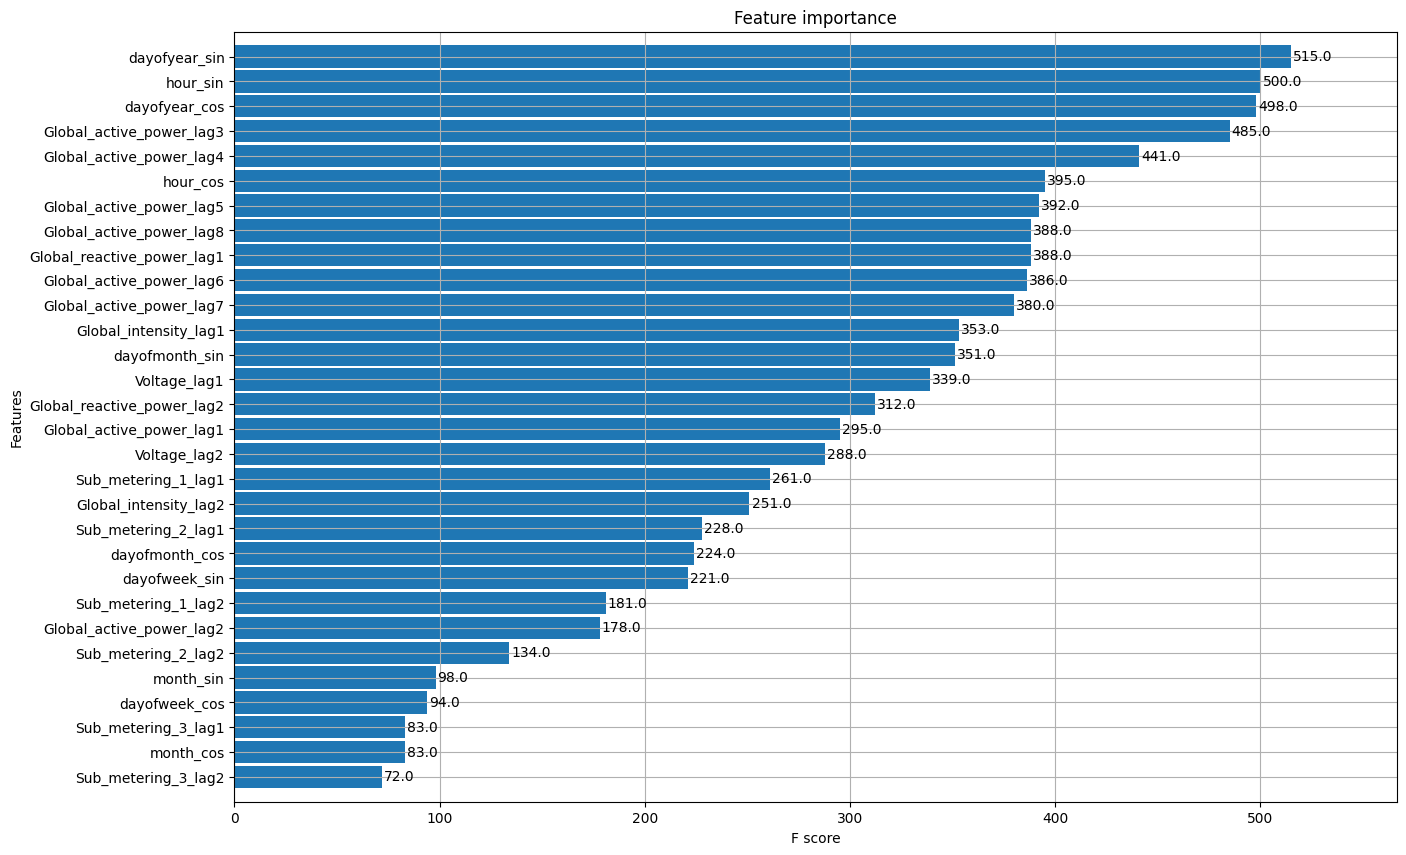

In [60]:
import xgboost as xgb
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

f, ax = plt.subplots(figsize=(15,10))
_ = xgb.plot_importance(reg, height=0.9,ax = ax)
plt.show()

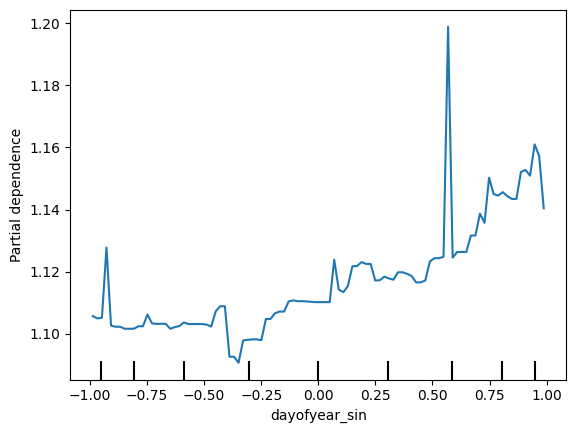

In [62]:
from sklearn.inspection import PartialDependenceDisplay

ax = plt.subplot(1, 1, 1)  # (rows, columns, index)
lr_disp = PartialDependenceDisplay.from_estimator(reg, X_train, features=["dayofyear_sin"],feature_names=X_train.columns,ax=ax)
plt.show()
